In [1]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd '/content/gdrive/My Drive'

/content/gdrive/My Drive


In [3]:
cd '/content/gdrive/My Drive/Real_time_HW3'

/content/gdrive/My Drive/Real_time_HW3


In [4]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch import nn

In [5]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn


In [7]:
pip install d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
pip install --upgrade d2l==1.0.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 KB 9.3 MB/s eta 0:00:00
  Attempting uninstall: d2l
    Found existing installation: d2l 0.17.6
    Uninstalling d2l-0.17.6:
      Successfully uninstalled d2l-0.17.6


In [9]:

pip install matplotlib_inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from d2l import torch as d2l

In [11]:
import torchvision.transforms as transforms

In [12]:
data_dir = './data' 
transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(),transforms.Resize(64)])
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True)
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [13]:

print(len(trainset))
sample = next(iter(trainset))
print(len(sample))
image, label = sample
print(type(image))
print(type(label))
image.shape
print(len(testset))

50000
2
<class 'torch.Tensor'>
<class 'int'>
10000


truck


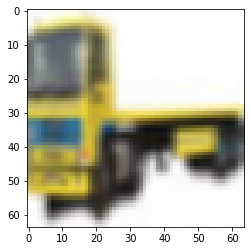

plane


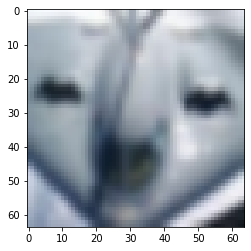

bird


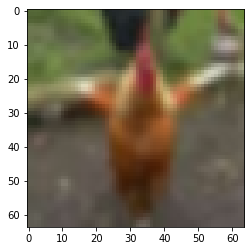

car


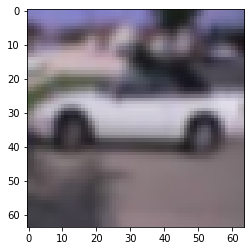

car


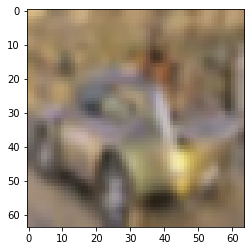

cat


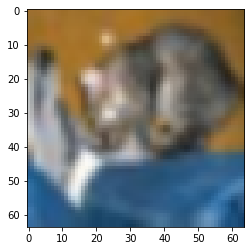

ship


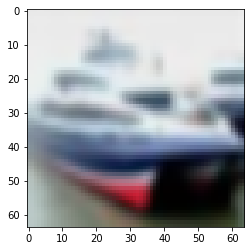

ship


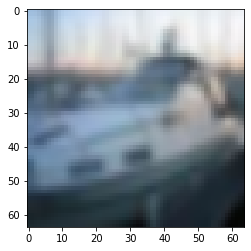

plane


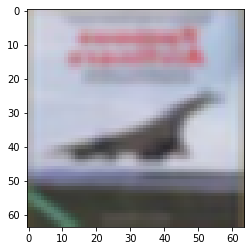

frog


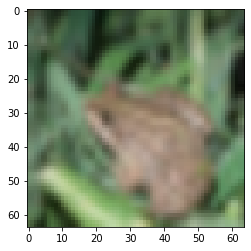

In [14]:
import matplotlib.pyplot as plt
import numpy as np
# train_loader images
dataiter = iter(train_loader)
batch = next(dataiter)
labels = batch[1][0:5]
images = batch[0][0:5]
for i in range(5):
    print(classes[labels[i]])
    image = images[i].numpy()
    plt.imshow(np.rot90(image.T, k=3))
    plt.show()
# test_loader images
dataiter = iter(test_loader)
batch = next(dataiter)
labels = batch[1][0:5]
images = batch[0][0:5]
for i in range(5):
    print(classes[labels[i]])
    image = images[i].numpy()
    plt.imshow(np.rot90(image.T, k=3))
    plt.show()

In [15]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [16]:
class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [17]:
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1),
        nn.LazyBatchNorm2d(),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [18]:
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [19]:
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [20]:
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

In [21]:
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

In [22]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [23]:
GoogleNet()

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


GoogleNet(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Inception(
        (b1_1): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
        (b2_1): LazyConv2d(0, 96, kernel_size=(1, 1), stride=(1, 1))
        (b2_2): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (b3_1): LazyConv2d(0, 16, kernel_size=(1, 1), stride=(1, 1))
        (b3_2): LazyConv2d(0, 32,

In [24]:
model = GoogleNet(lr=0.01)

In [25]:
import torch.optim as optim

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [27]:
device = 'cuda' 
model.to(device)

GoogleNet(
  (net): Sequential(
    (0): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): LazyConv2d(0, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Inception(
        (b1_1): LazyConv2d(0, 64, kernel_size=(1, 1), stride=(1, 1))
        (b2_1): LazyConv2d(0, 96, kernel_size=(1, 1), stride=(1, 1))
        (b2_2): LazyConv2d(0, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (b3_1): LazyConv2d(0, 16, kernel_size=(1, 1), stride=(1, 1))
        (b3_2): LazyConv2d(0, 32,

1,  2000| loss: 2.308
1,  4000| loss: 2.307
1,  6000| loss: 2.308
1,  8000| loss: 2.308
1, 10000| loss: 2.307
2,  2000| loss: 2.307
2,  4000| loss: 2.307
2,  6000| loss: 2.306
2,  8000| loss: 2.308
2, 10000| loss: 2.307
3,  2000| loss: 2.307
3,  4000| loss: 2.306
3,  6000| loss: 2.307
3,  8000| loss: 2.308
3, 10000| loss: 2.306
4,  2000| loss: 2.307
4,  4000| loss: 2.308
4,  6000| loss: 2.307
4,  8000| loss: 2.307
4, 10000| loss: 2.307
5,  2000| loss: 2.307
5,  4000| loss: 2.307
5,  6000| loss: 2.307
5,  8000| loss: 2.307
5, 10000| loss: 2.306
6,  2000| loss: 2.308
6,  4000| loss: 2.307
6,  6000| loss: 2.308
6,  8000| loss: 2.308
6, 10000| loss: 2.307
7,  2000| loss: 2.307
7,  4000| loss: 2.308
7,  6000| loss: 2.307
7,  8000| loss: 2.308
7, 10000| loss: 2.307
8,  2000| loss: 2.307
8,  4000| loss: 2.307
8,  6000| loss: 2.308
8,  8000| loss: 2.307
8, 10000| loss: 2.306
9,  2000| loss: 2.308
9,  4000| loss: 2.308
9,  6000| loss: 2.307
9,  8000| loss: 2.306
9, 10000| loss: 2.307
10,  2000|

Text(0.5, 1.0, 'Convergence of Loss')

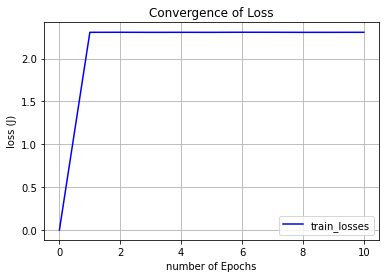

In [28]:
epoch_losses = [] 
model.train()
n_epochs=10
train_losses = np.zeros(n_epochs+1)
val_losses = np.zeros(n_epochs+1)
for epoch in range(n_epochs):
    
    running_loss = 0.0
    saved_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        

        loss.backward()
        optimizer.step()
       
        # print stats
        running_loss += loss.item()
        train_losses[epoch+1]=running_loss/2000
        if i % 2000 == 1999:  
            print('%d, %5d| loss: %.3f' %(epoch+1, i+1, running_loss/2000))
            saved_loss = running_loss
            running_loss = 0.0

    epoch_losses.append(saved_loss/10000)
    


plt.plot(train_losses, color = 'blue')
plt.rcParams["figure.figsize"] = (10, 6)
plt.legend(['train_losses', 'val_losses'])
plt.grid()
plt.xlabel('number of Epochs')
plt.ylabel('loss (J)')
plt.title('Convergence of Loss') 
   

In [29]:
total = 0
correct = 0
model.eval() 
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Model Accuracy: %d %%' % (100 * correct / total))

Model Accuracy: 10 %


In [30]:
pip install ptflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ptflops: filename=ptflops-0.6.9-py3-none-any.whl size=11712 sha256=60473ae456982cad85517cf32967d37a970285ad3b8b97fab4f7b311c9a3ee4d
  Stored in directory: /root/.cache/pip/wheels/86/07/9f/879035d99d7b639bbc564d23fed862a679aee7d1a2dced8c2e
Successfully built ptflops


In [31]:
sum([param.nelement() for param in model.parameters()])

5984186

In [32]:
pip install --upgrade git+https://github.com/sovrasov/flops-counter.pytorch.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/sovrasov/flops-counter.pytorch.git to /tmp/pip-req-build-49fomscx
  Running command git clone --filter=blob:none --quiet https://github.com/sovrasov/flops-counter.pytorch.git /tmp/pip-req-build-49fomscx
  Resolved https://github.com/sovrasov/flops-counter.pytorch.git to commit 64a8dbdfb8cd85d1d7bb1d3f7237b8eafec78005
  Preparing metadata (setup.py) ... done


In [33]:
import torchvision.models as models
import torch
from ptflops import get_model_complexity_info

with torch.cuda.device(0):
  net = model
  macs, params = get_model_complexity_info(net, (3, 64, 64), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
  print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
  print('{:<30}  {:<8}'.format('Number of parameters: ', params))

GoogleNet(
  5.98 M, 100.000% Params, 129.86 MMac, 100.000% MACs, 
  (net): Sequential(
    5.98 M, 100.000% Params, 129.86 MMac, 100.000% MACs, 
    (0): Sequential(
      9.47 k, 0.158% Params, 9.83 MMac, 7.570% MACs, 
      (0): Conv2d(9.47 k, 0.158% Params, 9.7 MMac, 7.469% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): ReLU(0, 0.000% Params, 65.54 KMac, 0.050% MACs, )
      (2): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.050% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      115.33 k, 1.927% Params, 29.64 MMac, 22.824% MACs, 
      (0): Conv2d(4.16 k, 0.070% Params, 1.06 MMac, 0.820% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU(0, 0.000% Params, 16.38 KMac, 0.013% MACs, )
      (2): Conv2d(110.78 k, 1.851% Params, 28.36 MMac, 21.840% MACs, 64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(384, 0.006% Params, 98.3 KMac, 0.076% MACs, 192, eps=1e-05, m